# Embeddings

## What are Embeddings?

So called "embeddings" are crucial for most One-Shot Learning approaches involving Deep Learning.

[But what is an embedding?](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture?hl=de)

- Relatively low-dimensional space
- Into which high-dimensional vectors can be translated
- Captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space
- Can be learned and reused across models

For a better understanding let's visualize some embeddings.

## Sign Language Classification

Since we need a Neural Network that produces the embeddings, we'll use the [sign language classifier from the previous project](https://www.kaggle.com/code/moritzkronberger/snn-0-94-acc) as an example.

To begin, we'll load the familiar dataset, split it into training and test sets and one-hot-encode the labels:

In [1]:
from core.dataset import DGSAlphabet

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_one_hot()

x_train = categorical_dataset.x_train
y_train = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

Since the original model's architecture was based on manual trial and error, let's use the Keras Tuner to systematically find the best possible model (of similar architecture):

In [2]:
from core.util import new_SNN_builder

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="classifier",
    loss="categorical_crossentropy",
    metrics=["acc"],
    num_classes=y_test[0].shape[0]
)

In [3]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 150
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42
VAL_SPLIT = 0.2

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "embeddings_classifier"

In [4]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_acc",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Reloading Tuner from tuner/embeddings_classifier/tuner0.json
Search space summary
Default search space size: 8
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
decoder_dropout (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


In [5]:
from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_acc",
    mode="max",
    lr_reduce_factor=0.2,
    lr_reduce_patience=5,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

Loading history from JSON tuner/embeddings_classifier/history.json


In [6]:
tuner.search(
    x_train,
    y_train,
    validation_split=VAL_SPLIT,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

In [7]:
tuner.results_summary()

Results summary
Results in tuner/embeddings_classifier
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 0208 summary
Hyperparameters:
dense_count: 6
dense_base: 64
encoder_dropout: False
decoder_dropout: False
start_lr: 0.0009500000000000001
beta_1: 0.7999999999999999
beta_2: 0.99
epsilon: 0.005
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0203
Score: 0.958939254283905

Trial 0209 summary
Hyperparameters:
dense_count: 6
dense_base: 48
encoder_dropout: False
decoder_dropout: False
start_lr: 0.0005
beta_1: 0.7
beta_2: 0.992
epsilon: 0.001
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0204
Score: 0.958939254283905

Trial 0203 summary
Hyperparameters:
dense_count: 6
dense_base: 64
encoder_dropout: False
decoder_dropout: False
start_lr: 0.0009500000000000001
beta_1: 0.7999999999999999
beta_2: 0.99
epsilon: 0.005
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/roun

Since we later want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [8]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Alternatively, if missing tuning checkpoints:
# Load model directly and skip history plots
# from keras.saving import load_model
# best_model = load_model(f"{MODEL_DIR}/embeddings_classifier.keras")
# best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, snn_classifier = build_model(best_hyper_params, get_encoder=True)
snn_classifier.set_weights(best_weights)

snn_classifier.summary()

Model: "SNN_6_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Input (InputLayer  [(None, 21, 3)]           0         
 )                                                               
                                                                 
 Layer_Norm (LayerNormaliza  (None, 21, 3)             6         
 tion)                                                           
                                                                 
 Flatten_Landmarks (Flatten  (None, 63)                0         
 )                                                               
                                                                 
 Dense_1 (Dense)             (None, 2304)              147456    
                                                                 
 Dense_2 (Dense)             (None, 1600)              3688000   
                                                  

Let's save the best model and take a look at its training history:

In [9]:
from pathlib import Path

MODEL_DIR = "models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

snn_classifier.save(f"{MODEL_DIR}/embeddings_classifier.keras")

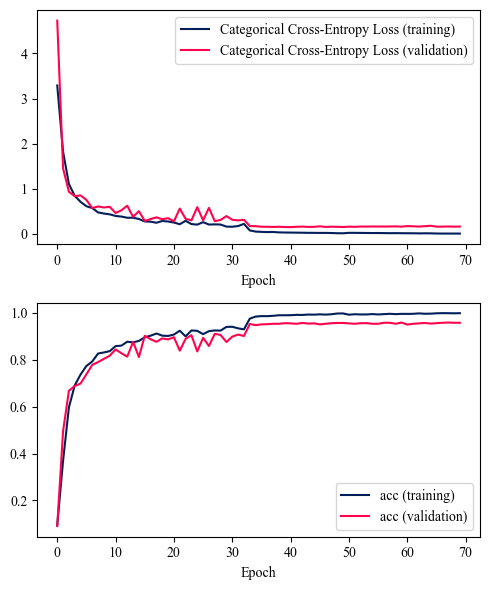

In [10]:
from core.viz import visualize_history

visualize_history(
    best_model_history,
    ["loss", "acc"],
    "Categorical Cross-Entropy Loss",
    filepath=None,
    figsize=(5, 6)
)

Its accuracy is still very close to our original results:

In [11]:
# And evaluate the model on test data
loss, acc = snn_classifier.evaluate(x_test, y_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.2408 acc=0.9535


## Embeddings Visualization

Now that we have our trained Neural Network we can start visualizing its embedding space.

The model's embedding layer usually refers to the last layer in the model's encoder portion, in our case the "Dense_6" layer.

As we can see in the model summary, the layer has an output dimension of 64, which is impractical to visualize.

We'll therefore need to reduce the embeddings' dimensions. A popular approach for this is t-SNE (t-Distributed Stochastic Neighbor Embedding).

Let's use [ScikitLearn's t-SNE implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to have a look at our classification embeddings:

In [12]:
# And get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

46/46 [==============================] - 0s 3ms/step


ScikitLearn recommends further dimensionality-reduction before applying t-SNE if the dimensions are higher than ~50.
We'll assume that 64 is close enough and use t-SNE straight away:

In [13]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1462 samples in 0.000s...
[t-SNE] Computed neighbors for 1462 samples in 0.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1462
[t-SNE] Computed conditional probabilities for sample 1462 / 1462
[t-SNE] Mean sigma: 18.636244
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.379425
[t-SNE] KL divergence after 1000 iterations: 0.376121


If we take a look at our embeddings (which are now reduced to 2 dimensions), we can see how embeddings for different categories are separated in space.

It is easy to imagine, that comparing the distance between embeddings could be used as a way to judge the similarity of model inputs:

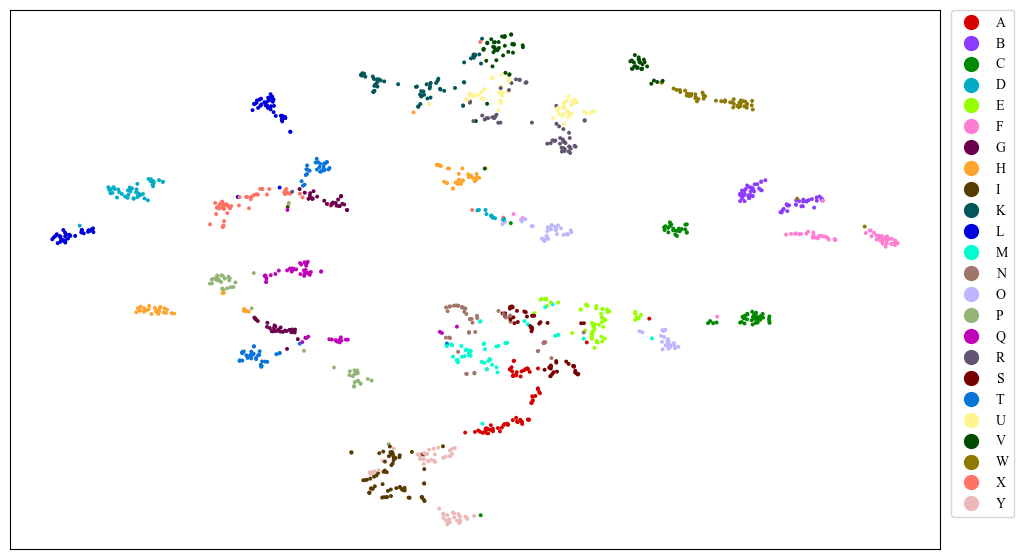

In [14]:
import numpy as np
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
y_test_int_labels = np.argmax(y_test, axis=1)
visualize_embeddings(
    reduced_embeddings,
    y_test_int_labels,
    label_map,
    filepath=None,
    figsize=(12, 7)
)

Finally, let's compare the embeddings' visualization to our model's confusion matrix.

We can not only see that our model seems to perform extremely well, we can also make correlations between class confusions and overlaps in the embedding space: 

46/46 [==============================] - 0s 4ms/step


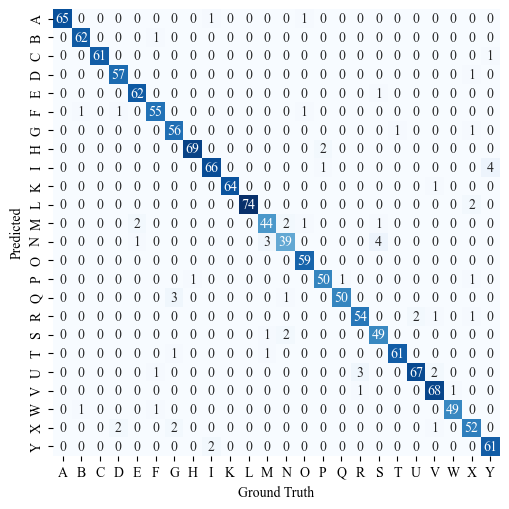

In [15]:
from core.viz import visualize_confusion_matrix


predictions = snn_classifier.predict(x_test)

prediction_classes = np.argmax(predictions, axis=-1)
gt_classes = np.argmax(y_test, axis=-1)
pretty_classes = [lbl.upper() for lbl in label_map.keys()]

visualize_confusion_matrix(
    gt_classes,
    prediction_classes,
    pretty_classes,
    filepath=None
)

Now that we know how embeddings can be used to judge the similarity of model inputs, we can apply this practice for One-Shot Learning in form of [Contrastive Loss](./contrastive_loss.ipynb).